# Chapter 6 - Tree-Based Methods
The following excercises, code, and explanations are adapted from An Introduction to Statistical Learning with Applications in Python (ISLP) (James, Witten, Hastie, Tibshirani, and Taylor 2023).

Make sure the following packages are installed prior to running code in this notebook:

- `numpy`
- `matplotlib`
- `seaborn`
- `ISLP`
- `sklearn`

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ISLP import load_data
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error

# Exercise: `Carseats` dataset
This exercise is adapted from Chapter 8, Exercise 8 in ISLP. 
This problem invovles the `Carseats` from the `ISLP` pacakge. This is a simulated data set containing the sales of child car seats at 400 different stores. The variables include:
 - `Sales`: Unit sales (in thousands) at each location
 - `CompPrice`: Price charged by competitor at each location
 - `Income`: Community income level (in thousands of dollars)
 - `Advertising`: Local advertising budget for company at each location (in thousands of dollars)
 - `Population`: Population size in region (in thousands)
 - `Price`: Price company charges for car seats at each site
 - `ShelveLoc`: A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
 - `Age`: Average age of the local population
 - `Education`: Education level at each location
 - `Urban`: A factor with levels No and Yes to indicate whether the store is in an urban or rural location
 - `US`: A factor with levels No and Yes to indicate whether the store is in the US or not

The goal of this exercise is to predict `Sales` using regression trees and related approaches, treating the response as a quantitative variable.

First we will load in the data and inspect the first few rows.

In [13]:
carseats = load_data("Carseats")
carseats.head(n = 5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


Here we transform the qualitative variables into quantitative variables to enable the use of regressors. Then we split the data set into a training set and a test set.

In [14]:
carseats = pd.get_dummies(carseats)
X = carseats.drop('Sales', axis = 1)
y = carseats['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

### Part 1: Full Regression Tree

We start by fitting a regression tree to the training set. We can do this in Python using the `DecisionTreeRegressor` function. Then we plot the tree and compute the MSE on the testing set.

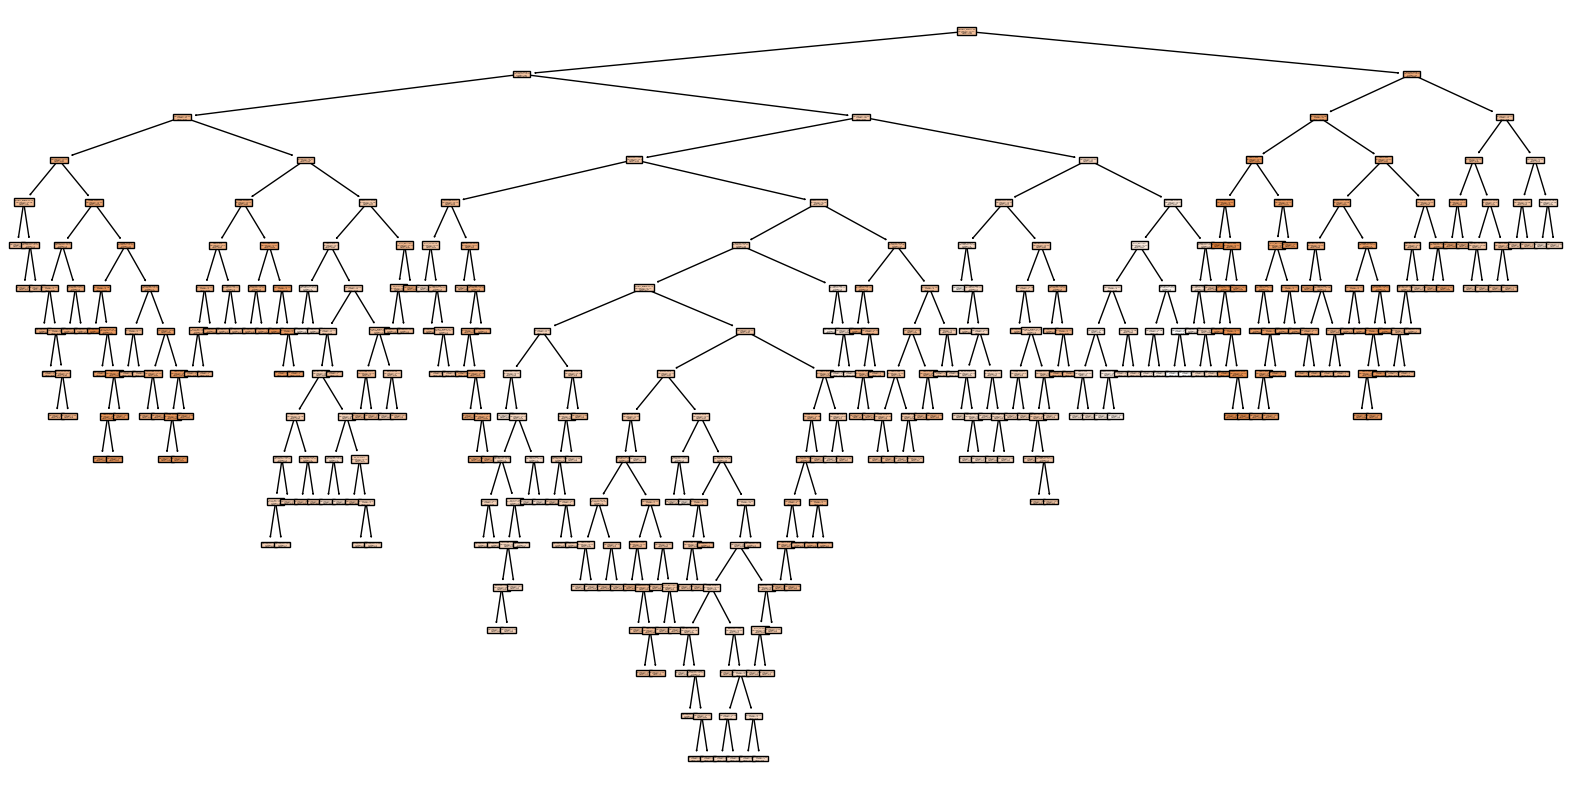

Full Tree test MSE: 6.5957925


In [15]:
full_tree = DecisionTreeRegressor(random_state = 42)
full_tree.fit(X_train, y_train)

plt.figure(figsize = (20, 10))
tree.plot_tree(full_tree, filled = True, feature_names = list(X.columns))
plt.show()

y_pred = full_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Full Tree test MSE: {mse}')

Note: There is actually information in each leaf node (orange box) including, the split criterion, training MSE, and sample size, but it is too small to read in this figure.

### Part 2: Tree Pruning

Next we use cross-validataion to determine the optimal level of tree complexity. That is through cross-validation we prune our tree to the optimal depth.

In [16]:
depths = range(1, 21)
cv_scores = [cross_val_score(DecisionTreeRegressor(max_depth = d, random_state = 42), 
                X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error').mean() 
             for d in depths]

best_depth = depths[np.argmax(cv_scores)]
print(f'Optimal tree depth: {best_depth}')

Optimal tree depth: 4


It appears that the optimal tree depth is 4, thus we fit a regression tree to the training data with a maximum depth of 4. We can do this using the `max_depth` argument in the `DecisionTreeRegressor` function. Once again we plot the tree, and compute the MSE on the testing set.

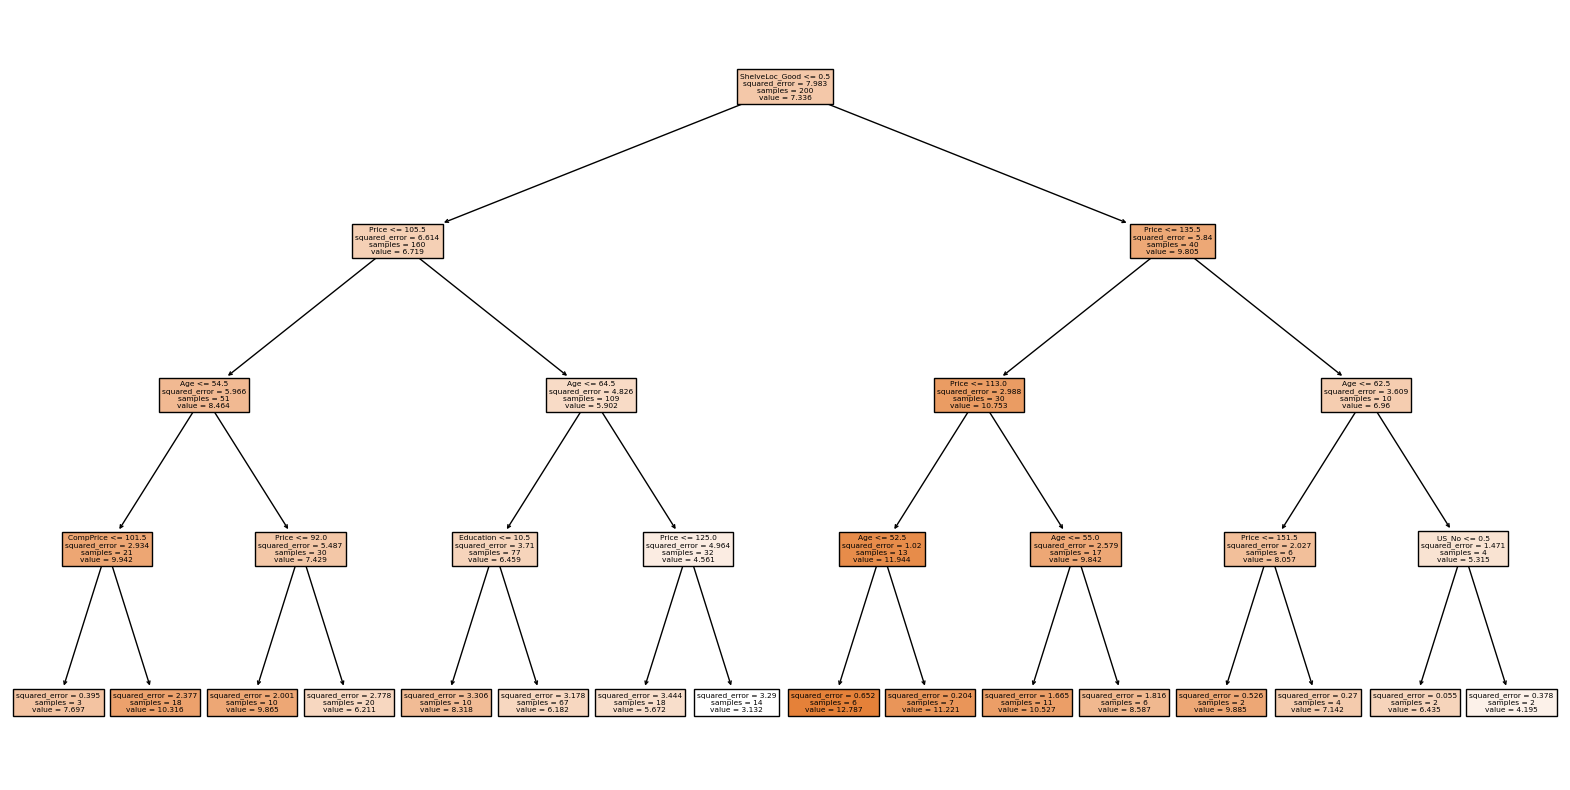

Pruned Tree test MSE: 5.537709451031239


In [17]:
pruned_tree = DecisionTreeRegressor(max_depth = best_depth, random_state = 42)
pruned_tree.fit(X_train, y_train)

plt.figure(figsize = (20, 10))
tree.plot_tree(pruned_tree, filled = True, feature_names = list(X.columns))
plt.show()

y_pred_pruned = pruned_tree.predict(X_test)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)
print(f'Pruned Tree test MSE: {mse_pruned}')

We see that pruning the tree resulted in a tree with a smaller test MSE. It is interesting to investigate the splits resulting nodes (as this tree can be read unlike our first tree). Take a minute to look at what variables are being split on, the training MSE in each leaf node, and even the number of samples each node contains.

### Part 3: Bagging

So far we have only built a single regression tree. Now we will create multiple trees (or a forest) using the `RandomForestRegressor` function. We define the number of trees in our forest using the `n_estimators` argument. Our final predictions are averaged from the predictions of each individual regression tree created. 

To implement bagging we must specify `bootstrap = True`. For the default, `False`, every datapoint is used when creating each tree. Specify `True` means a bootstrapped sample is used to create each tree. Here we run the random forest which is creating 50 individual trees. The test MSE is then computed. 

Note: Since multiple trees are being built it is not possible to plot a random forest, although you could plot each of the 50 trees. 

In [18]:
bagging_for = RandomForestRegressor(n_estimators = 50, bootstrap = True, random_state = 42)
bagging_for.fit(X_train, y_train)

y_pred_bagging = bagging_for.predict(X_test)
mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print(f'Bagging test MSE: {mse_bagging}')

Bagging test MSE: 2.966408745199999


The test MSE from this random forest is much lower than the test MSE of an individual tree. 

### Part 4: Tuning Parameters 

Now we will look at some other arguments to the `RandomForestRegressor` function that can be tuned by the user. A brief list of tunable parameters are:
 - `n_estimators`: The number of trees in the forest (defaults to 100)
 - `max_depth`: Maximum depth of the tree (defaults to "None", this can result in very large trees!) 
 - `min_samples_split`: The minimum number of samples required to split an internal node (defaults to 2)
 - `min_samples_leaf`: The minimum number of samples required to be at a leaf node (defaults to 1)
 - `max_features`: The number of features to consider when looking for the best split (defaults to 1, that is 100% of the features)

See the [help page](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for `RandomForestRegressor` to get more information on these arguments and other arguments not listed above. 

Now we will fit a tree with some of these other arguments defined. Once again we are implementing bagging. 

In [19]:
tuned_for = RandomForestRegressor(n_estimators = 200, max_depth = 10, bootstrap = True, 
    min_samples_split = 5, min_samples_leaf = 3, max_features = 0.7, random_state = 42)
tuned_for.fit(X_train, y_train)

y_pred_tuned = tuned_for.predict(X_test)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
print(f'Tuned Forest test MSE: {mse_tuned}')

Tuned Forest test MSE: 2.8841436743307294


The test MSE for this tuned forest is slightly smaller than the test MSE from the bagging example above. 

Note: This was not extensively tuned and the decrease is almost surely from the number of trees increasing. One way to tune models fairly comprehensively is by tuning over a grid of parameter settings to find the optimal parameter setting. While being a solid approach, it tends to be very computationally intensive as the number of models fit grows quite large given the number of parameters being tuned and the number of levels for each parameter. 

### Part 5: Feature Importance 

Finally, we look at feature importance from the random forest. Feature importance is provided by the fitted attribute `feature_importances_` which shows which variables are most important. Using our tuned forest from the previous section we can investigate feature importance.

In [20]:
feature_importance = tuned_for.feature_importances_
print(feature_importance)

[0.0717947  0.04774404 0.07678853 0.03310584 0.33066028 0.16945703
 0.03241217 0.05021904 0.15095311 0.02215752 0.00367832 0.00403046
 0.00306112 0.00393786]


This is not a great output as it is hard to compare so we will plot the feature importance using a bar chart.

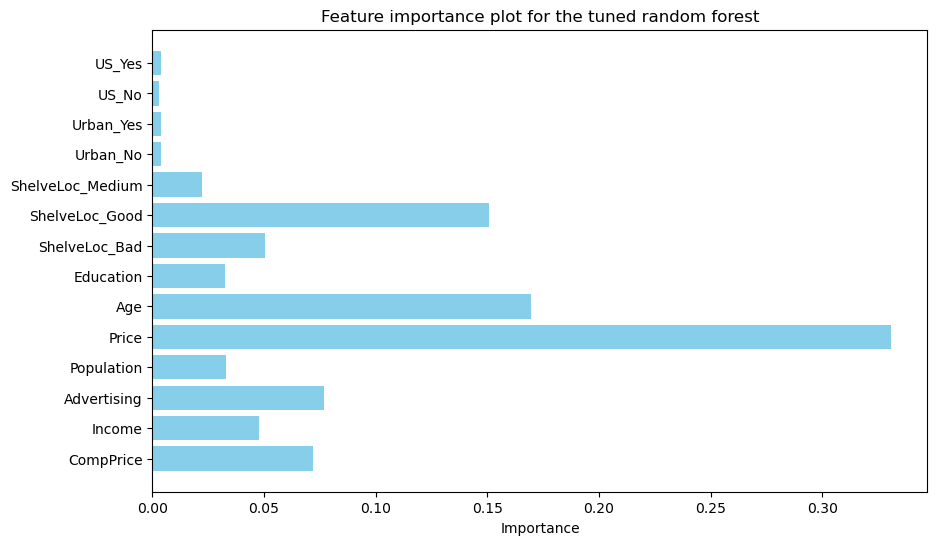

In [21]:
feature_names = X.columns
plt.figure(figsize = (10, 6))
plt.barh(feature_names, feature_importance, color = 'skyblue')
plt.xlabel('Importance')
plt.title('Feature importance plot for the tuned random forest')
plt.show()

We see that `Price` appears to be the most important feature in the model while both `Urban` and `US` seem to be the least important. While the numbers on the x-axis have meaning, it is better to compare the bars relative to one another when determining importance.

Note: There are multiple ways to look at variable importance in random forests. This method uses the mean accumulation of the impurity decrease within each tree. Other methods include permutation importance which looks at the mean accuracy decrease when the values of a feature are permutated and SHAP values, which look at the marginal contribution of a feature to predictions. 